# Data Cleaning

In [25]:
from google.colab import drive
import pandas as pd
import numpy as np
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import calendar, re
from datetime import datetime, timedelta
import ipywidgets as widgets

In [2]:
# =======================
# 2) Mount / paths / read attrs / helpers
# =======================
drive.mount('/content/drive')

# Paths
file_path1 = "/content/drive/MyDrive/IOE 424 (Gemline)/Data/SKU Data/SKU Attributes Report V2.xlsx"
file_path2 = "/content/drive/MyDrive/IOE 424 (Gemline)/Data/Sales and Pricing data/V3_Jan. 2022 to August 2025 Sales and Price data.xlsx"

# Read SKU attributes
df_sku_attributes = pd.read_excel(file_path1, engine="openpyxl")
df_sku_attributes.columns = df_sku_attributes.columns.str.strip()
df_sku_attributes["Item"] = df_sku_attributes["Item"].astype(str).str.strip()

# Category code -> friendly name
category_dict = {
    "*":      "COMMON",
    "BACKP":  "Backpack",
    "BBAGS":  "Business Bag",
    "COOL":   "Cooler",
    "DRINK":  "Drinkware",
    "DUF":    "Duffels",
    "FOOD":   "Food",
    "PAD":    "Padfolio",
    "STNRY":  "Stationery",
    "TECH":   "Technology",
    "TOTE":   "Totes",
    "TRAVL":  "Travel",
    "WRITE":  "Writing",
    "LFSTY":  "Lifestyle",
    "PPE":    "Personal Protective Equip.",
    "UMBR":   "Umbrellas",
    "HDWR":   "Headwear",
    "PKG":    "Packaging",
    "BLKTW":  "Blankets and Towels",
    "HOME":   "Home",
    "OFFCE":  "Office",
    "OUTDR":  "Outdoor",
    "SLWPK":  "Slings and Waist Packs",
}

# Robust column resolver
def find_col(cols, target):
    t = target.lower()
    for c in cols:
        if c.lower() == t:
            return c
    def norm(s): return s.lower().replace(' ', '').replace('_', '')
    nt = norm(target)
    for c in cols:
        if norm(c) == nt:
            return c
    return None

# Resolve commonly used columns
col_category     = find_col(df_sku_attributes.columns, "Category")
col_intro        = find_col(df_sku_attributes.columns, "Intro Code")
col_subcat       = find_col(df_sku_attributes.columns, "Subcategory Desc")
col_commgroup2   = find_col(df_sku_attributes.columns, "CommGroup2 Desc")
col_status       = find_col(df_sku_attributes.columns, "Status Code")


Mounted at /content/drive


## Dropping Missing Subcategory/CommGroup2 Entries

In [3]:
# =======================
# 3) Clean attributes
# =======================
if (col_subcat is None) or (col_commgroup2 is None):
    raise KeyError("Missing 'Subcategory Desc' and/or 'CommGroup2 Desc' in SKU attributes.")

df_attr_clean = df_sku_attributes.copy()

# Normalize strings
for c in ["Item", col_subcat, col_commgroup2]:
    df_attr_clean[c] = df_attr_clean[c].astype(str).str.strip()

# Drop NA-like values or blanks in Subcategory/CommGroup2
na_like = {"", "na", "n/a", "null", "none", "nan", "-", "--", "—"}
for c in [col_subcat, col_commgroup2]:
    df_attr_clean[c] = df_attr_clean[c].apply(lambda x: None if str(x).strip().lower() in na_like else x)
    df_attr_clean[c] = df_attr_clean[c].replace(r"^\s+$", None, regex=True)

before_attr = len(df_attr_clean)
df_attr_clean = df_attr_clean.dropna(subset=[col_subcat, col_commgroup2])
after_attr = len(df_attr_clean)

print(f"[Dropping] {before_attr - after_attr} rows dropped from SKU attributes (missing Subcategory/CommGroup2).")
print(f"[Dropping] Remaining attribute rows: {len(df_attr_clean):,}")


[Dropping] 271 rows dropped from SKU attributes (missing Subcategory/CommGroup2).
[Dropping] Remaining attribute rows: 2,138


## Merging 2022-2025 Sales Data

In [4]:
# =======================
# 4) Build combined_df (2022–2025)
# =======================
sheet_names = [str(y) for y in range(2022, 2026)]
sheet_dict = pd.read_excel(file_path2, sheet_name=sheet_names, engine="openpyxl")

rename_map = {"Planned Ship Date/Time": "ShipDate", "Sales Qty": "SalesQty"}
frames = []
for name, df in sheet_dict.items():
    df = df.copy()
    df.columns = df.columns.str.strip()
    df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})
    if "ShipDate" in df.columns:
        df["ShipDate"] = pd.to_datetime(df["ShipDate"], errors="coerce")
    if "SalesQty" in df.columns:
        df["SalesQty"] = pd.to_numeric(df["SalesQty"], errors="coerce").fillna(0)
    if "Item" in df.columns:
        df["Item"] = df["Item"].astype(str).str.strip()
    df["year"] = int(name)
    frames.append(df)

combined_df = pd.concat(frames, ignore_index=True)

# Drop rows missing ShipDate
combined_df = combined_df.dropna(subset=["ShipDate"]).reset_index(drop=True)

print(f"combined_df rows: {len(combined_df):,}")


combined_df rows: 624,603


## Merging Sales + SKU DataSets

In [5]:
# =======================
# 5) Merge Category info into sales data
# =======================
combined_df.columns = combined_df.columns.str.strip()
combined_df["Item"] = combined_df["Item"].astype(str).str.strip()

if col_category is None:
    raise KeyError("Could not find 'Category' column in attributes file.")

# Map Item → Category
sku_map = (
    df_attr_clean[["Item", col_category]]
      .drop_duplicates(subset="Item")
      .rename(columns={col_category: "Category"})
      .assign(Category=lambda d: d["Category"].astype("string").str.strip())
      .set_index("Item")["Category"]
)

combined_df["Category"] = combined_df["Item"].map(sku_map)
combined_df["CategoryName"] = combined_df["Category"].map(category_dict)

print(f"[Merge] Category merged into combined_df. Total rows: {len(combined_df):,}")
print(f"[Merge] Unmapped (no Category): {combined_df['Category'].isna().sum():,}")


[Merge] Category merged into combined_df. Total rows: 624,603
[Merge] Unmapped (no Category): 210,702


## Dropping OOC, PPE, PAD, NA

In [6]:
# =======================
# 6) Drop unwanted sales rows (OOC, PPE, PAD, <NA>)
# =======================
removed_counts = {}

# Intro Code = OOC*
if col_intro is not None:
    ooc_items = (
        df_attr_clean.loc[
            df_attr_clean[col_intro].astype(str).str.upper().str.startswith("OOC"),
            "Item"
        ].astype(str).unique()
    )
    mask_ooc = combined_df["Item"].astype(str).isin(ooc_items)
    removed_counts["Intro Code = OOC*"] = int(mask_ooc.sum())
    combined_df = combined_df[~mask_ooc]
else:
    removed_counts["Intro Code = OOC*"] = 0

# Category = PPE or PAD
mask_badcat = combined_df["Category"].astype(str).str.upper().isin(["PPE", "PAD"])
removed_counts["Category in {PPE, PAD}"] = int(mask_badcat.sum())
combined_df = combined_df[~mask_badcat]

# Category = <NA>
mask_na = combined_df["Category"].isna()
removed_counts["Category = <NA>"] = int(mask_na.sum())
combined_df = combined_df[~mask_na].reset_index(drop=True)

# Report
print("\nSummary of removed sales rows:")
for k, v in removed_counts.items():
    print(f"  {k}: {v}")
print(f"[Dropping] Remaining sales rows: {len(combined_df):,}")
print("[Dropping] Rows by year:")
print(combined_df["year"].value_counts().sort_index())



Summary of removed sales rows:
  Intro Code = OOC*: 1631
  Category in {PPE, PAD}: 0
  Category = <NA>: 210702
[Dropping] Remaining sales rows: 412,270
[Dropping] Rows by year:
year
2022     84254
2023    100481
2024    129199
2025     98336
Name: count, dtype: int64


# Category = Backpack Analysis

In [7]:
# ============================================================
# 7) Attach Subcategory + CommGroup2, then filter to BACKP
# ============================================================

# --- Normalize sales key ---
combined_df["Item"] = combined_df["Item"].astype(str).str.strip()

# --- Build minimal attribute slice (1 row per SKU) ---
attrs_slice = (
    df_attr_clean[["Item", col_subcat, col_commgroup2]]
      .drop_duplicates(subset="Item", keep="last")
      .rename(columns={
          col_subcat: "Subcategory Desc",
          col_commgroup2: "CommGroup2 Desc"
      })
)

# --- Merge into combined_df ---
combined_df = combined_df.merge(attrs_slice, on="Item", how="left")

# --- Quick sanity check ---
print(f"[Merge] Added Subcategory + CommGroup2 columns to combined_df.")
print("  Unique Subcategories:", combined_df["Subcategory Desc"].nunique())
print("  Unique CommGroup2 groups:", combined_df["CommGroup2 Desc"].nunique())

# --- Filter for Category = BACKP (Backpack) ---
backp_df = combined_df[combined_df["Category"].astype(str).str.upper() == "BACKP"].copy()
print(f"\n[Filter] Rows in Backpack category: {len(backp_df):,}")

# --- Optional: preview ---
display(backp_df.head(10)[["Item", "Category", "Subcategory Desc", "CommGroup2 Desc", "SalesQty"]])


[Merge] Added Subcategory + CommGroup2 columns to combined_df.
  Unique Subcategories: 64
  Unique CommGroup2 groups: 146

[Filter] Rows in Backpack category: 30,314


Item Category Subcategory Desc CommGroup2 Desc  SalesQty
16         5710    BACKP           Campus          Laptop       1.0
21         5340    BACKP           Campus     All Purpose       1.0
80         4894    BACKP            Event       Cinchpack     105.0
121        5387    BACKP         Commuter          Laptop     330.0
128  100066-001    BACKP            Event            Mini     100.0
129  100066-001    BACKP            Event            Mini      50.0
140        4842    BACKP           Campus     All Purpose     130.0
141  100066-001    BACKP            Event            Mini       4.0
146        5540    BACKP           Campus          Laptop       2.0
180  100215-001    BACKP         Commuter          Laptop      70.0

## Shard Code Helpers {Backpack}

In [8]:
# ================================================================
# Shared helpers for BACKP plots/tables (run once)
# ================================================================
YEARS      = [2022, 2023, 2024, 2025]
DUMMY_YEAR = 2001
WEEK_MON   = "W-MON"
WEEK_SUN   = "W-SUN"
MONTH_RULE_OVERLAY = "MS"  # month-start for overlays
MONTH_RULE_PIVOT   = "ME"  # keep your original pivot rule

def _prep(backp_df):
    df = backp_df.copy()
    df["ShipDate"] = pd.to_datetime(df["ShipDate"], errors="coerce")
    df["SalesQty"] = pd.to_numeric(df["SalesQty"], errors="coerce").fillna(0)
    df = df.dropna(subset=["ShipDate"])
    df["Subcategory Desc"] = df["Subcategory Desc"].astype("string").str.strip()
    df["CommGroup2 Desc"]  = df["CommGroup2 Desc"].astype("string").str.strip()
    if "year" not in df.columns:
        df["year"] = df["ShipDate"].dt.year
    return df

def weekly_dummy_align(s, week_rule=WEEK_MON, dummy_year=DUMMY_YEAR):
    if s.empty:
        return s
    s = s.asfreq(week_rule, fill_value=0)
    weeknum = s.index.isocalendar().week.astype(int)
    jan1 = datetime(dummy_year, 1, 1)
    first_monday = jan1 + timedelta(days=(7 - jan1.weekday()) % 7)
    dummy_dates = [first_monday + timedelta(days=(w - 1) * 7) for w in weeknum]
    s.index = pd.to_datetime(dummy_dates)
    return s.groupby(s.index).sum().sort_index()

def monthly_dummy_align(df_sub, month_rule=MONTH_RULE_OVERLAY, dummy_year=DUMMY_YEAR):
    m = df_sub.set_index("ShipDate")["SalesQty"].resample(month_rule).sum()
    if m.empty:
        return m
    months = m.index.month
    mapped_idx = pd.to_datetime([f"{dummy_year}-{int(mo):02d}-01" for mo in months])
    m.index = mapped_idx
    return m.groupby(m.index).sum().sort_index()


## Backpack Weekly Graph Sales

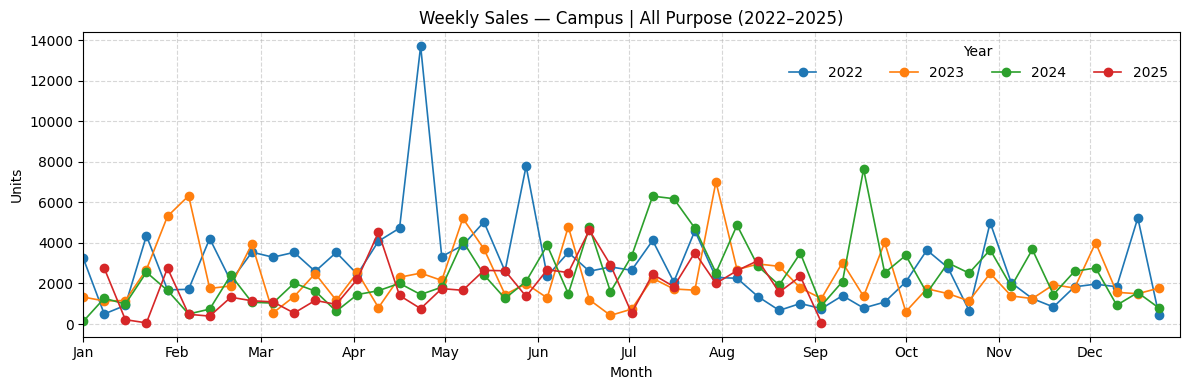

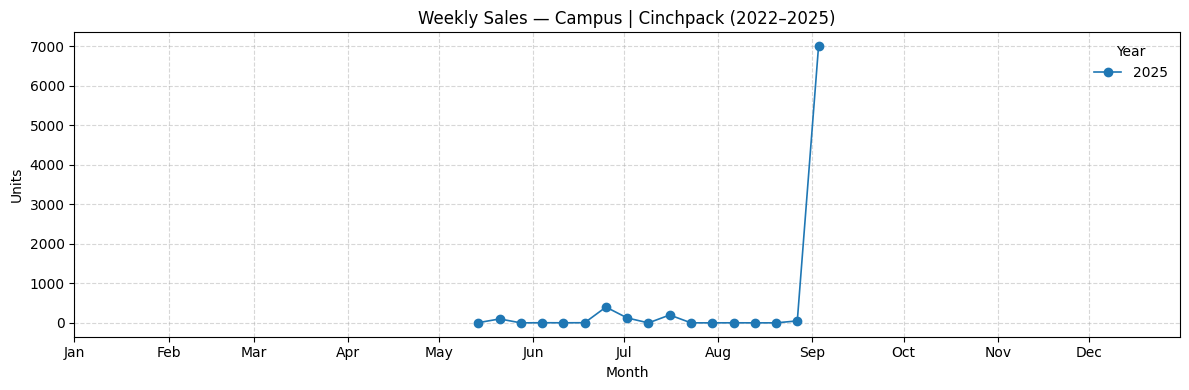

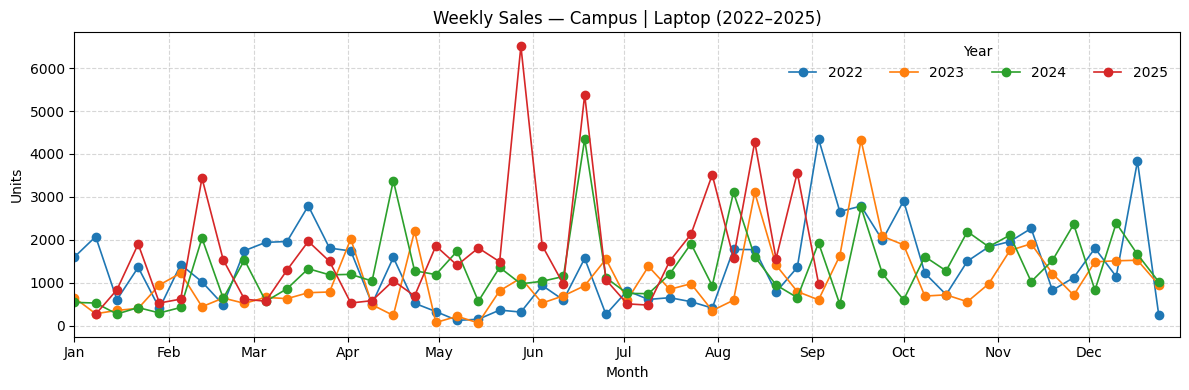

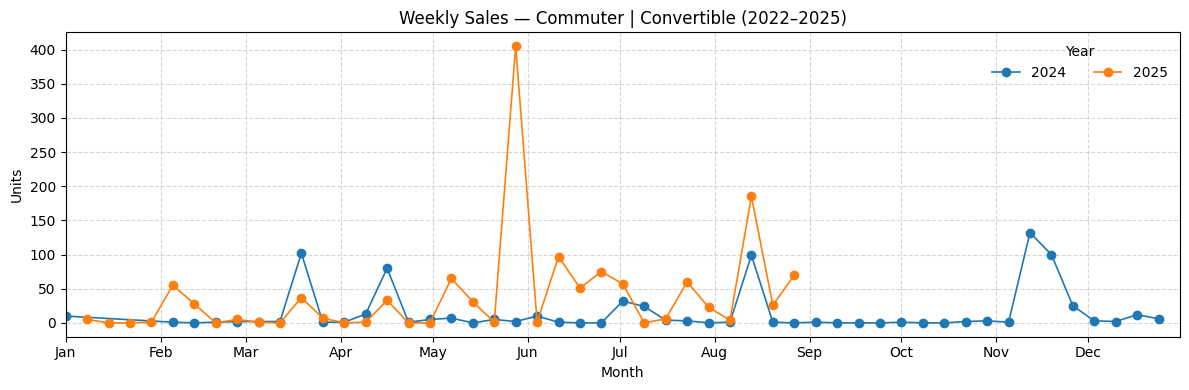

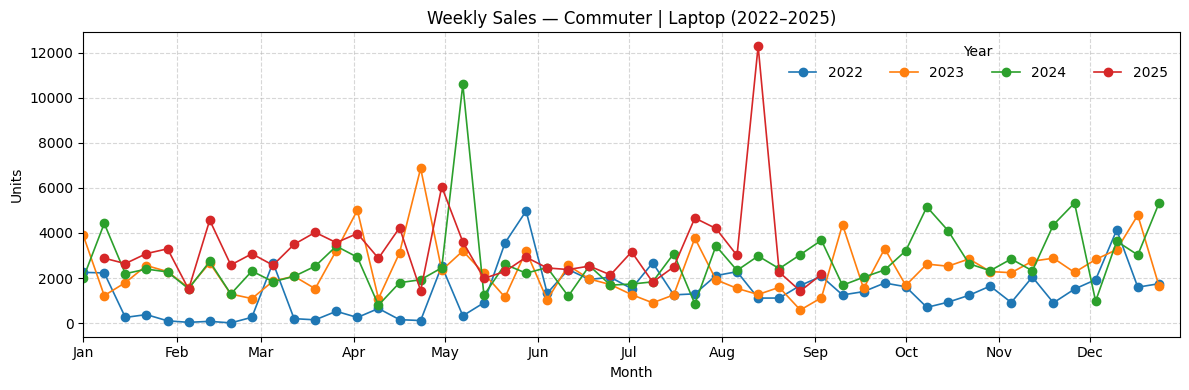

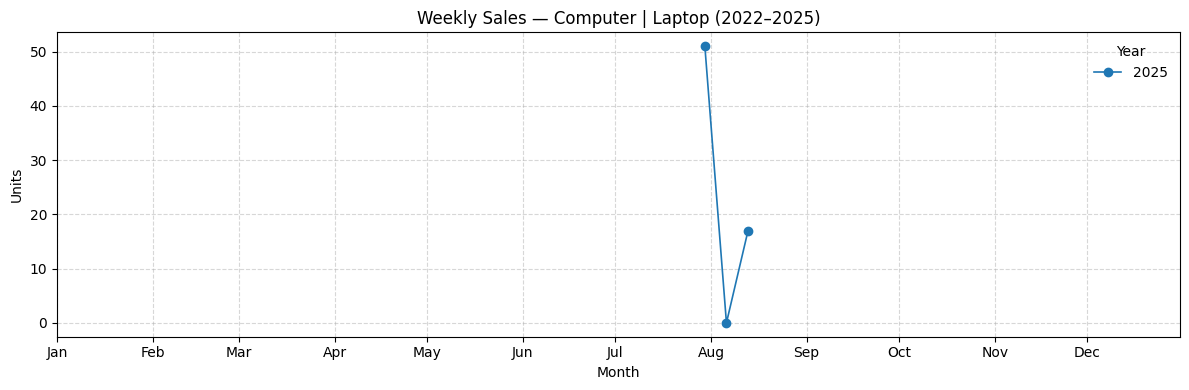

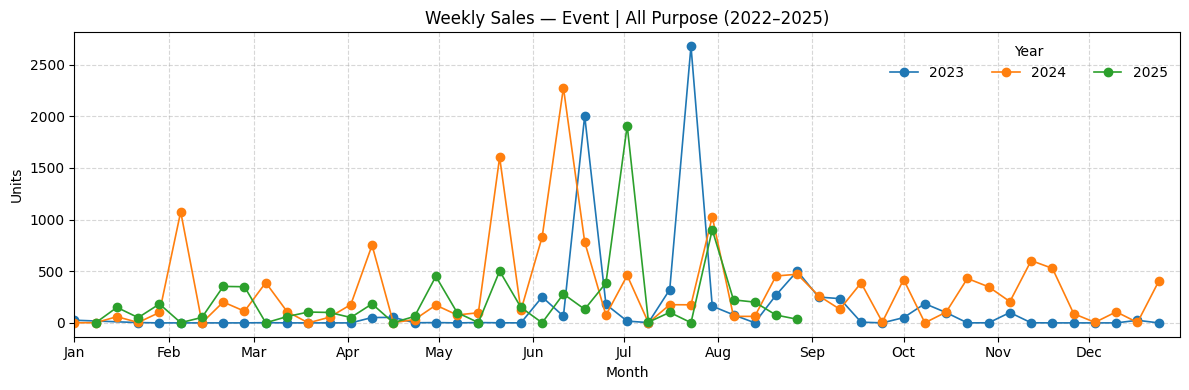

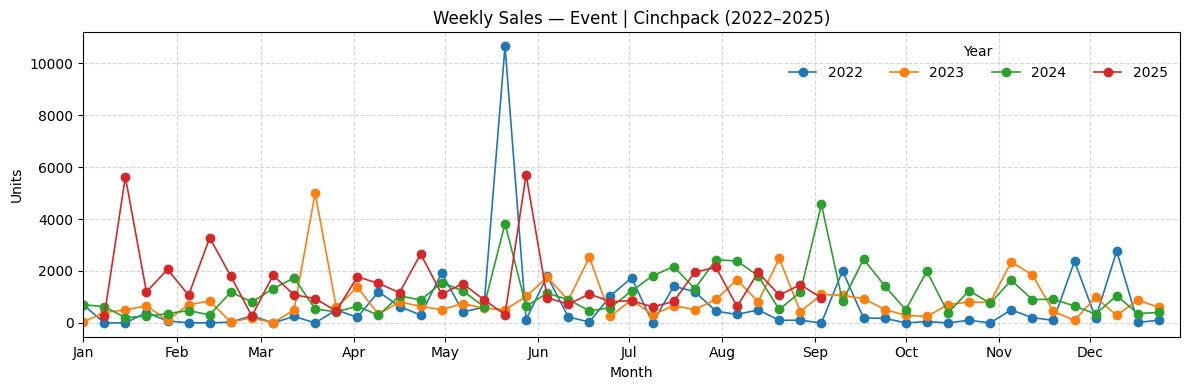

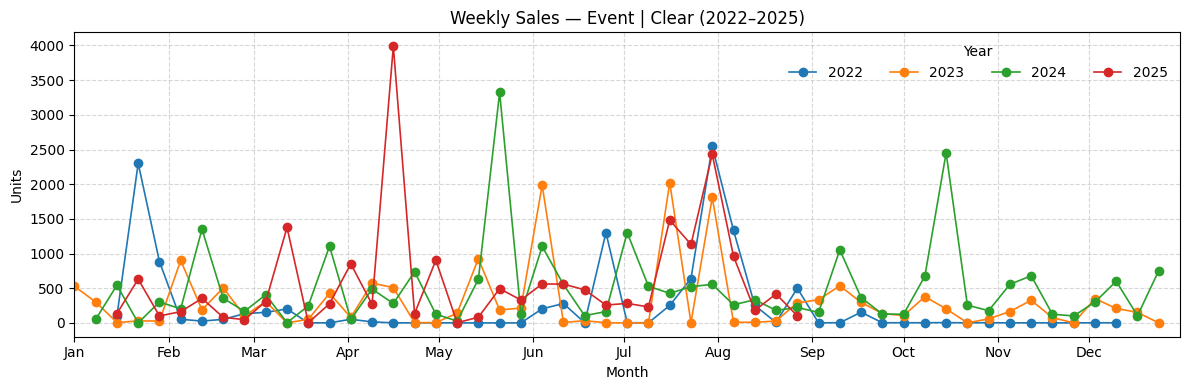

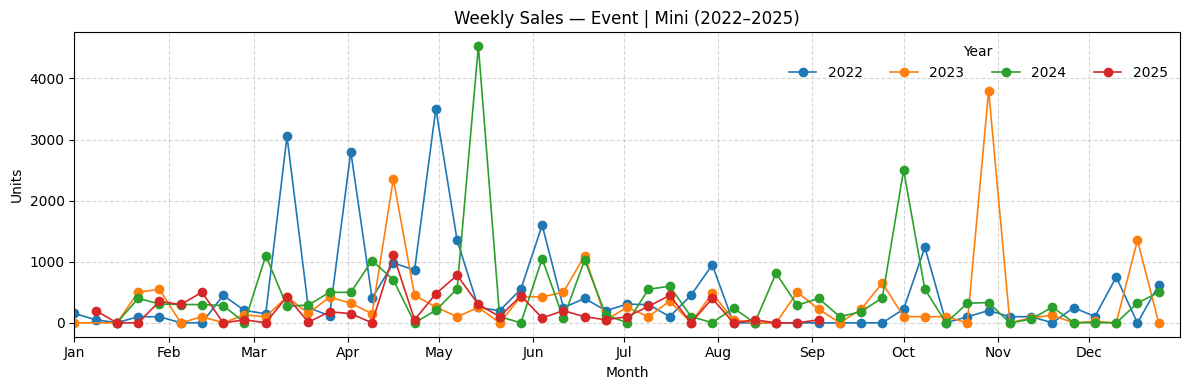

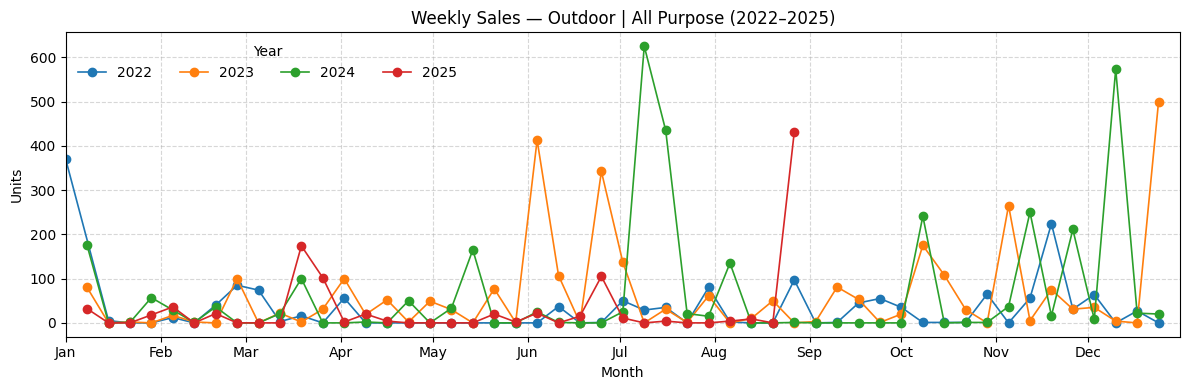

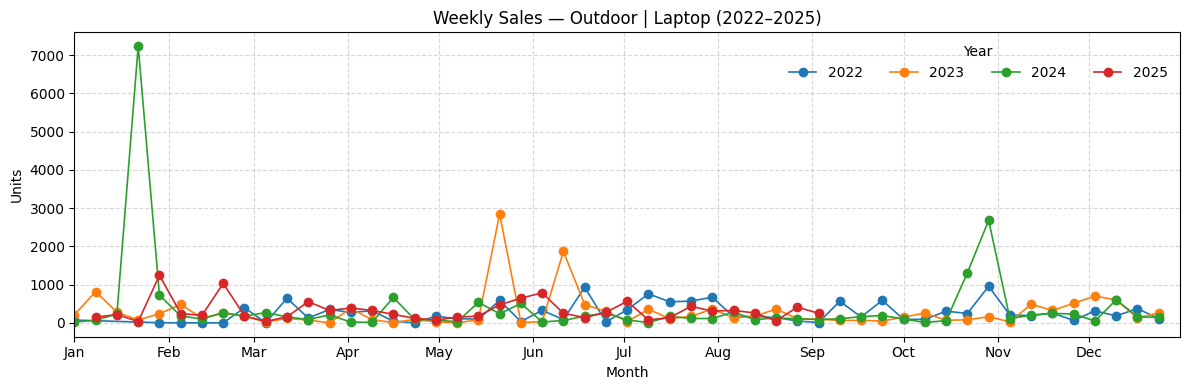

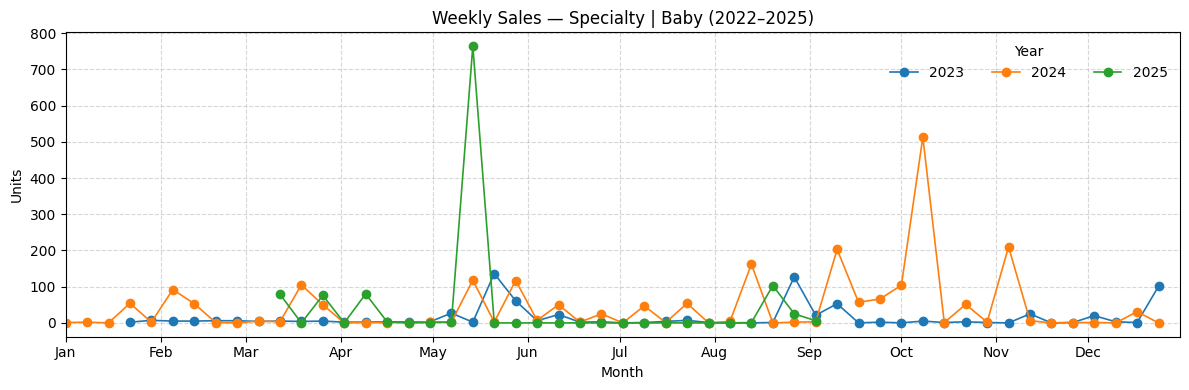

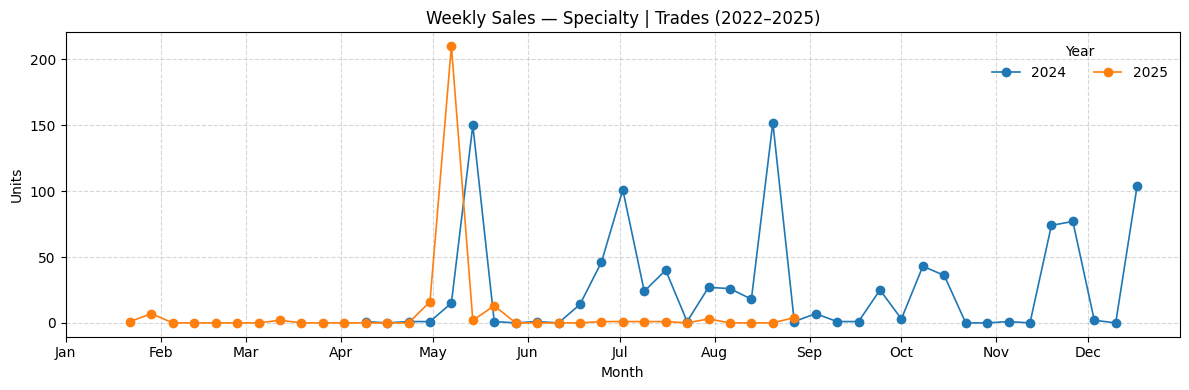

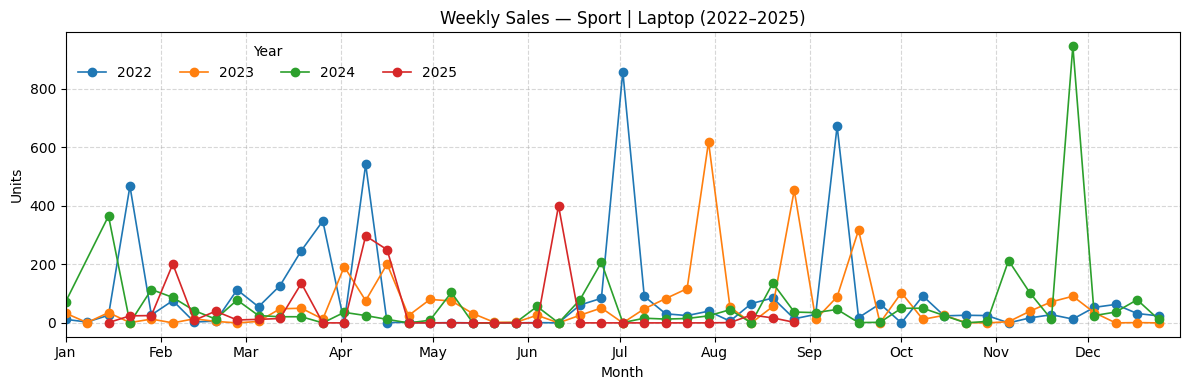

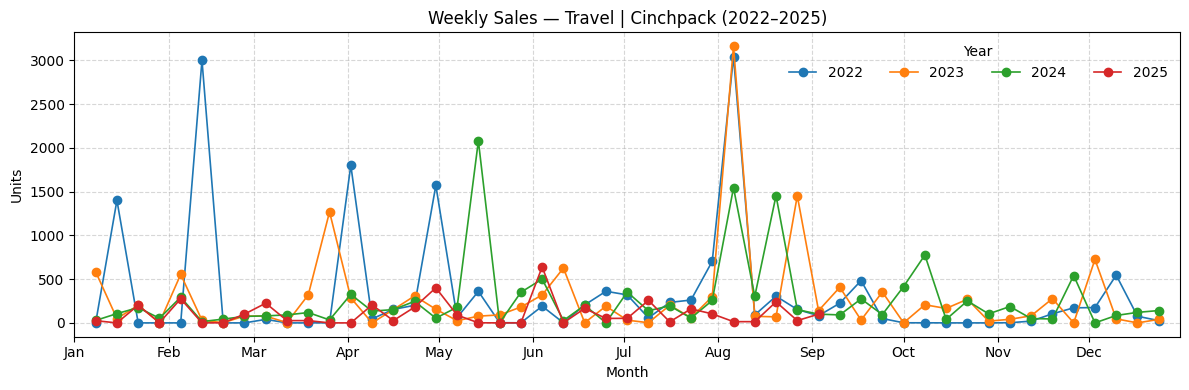

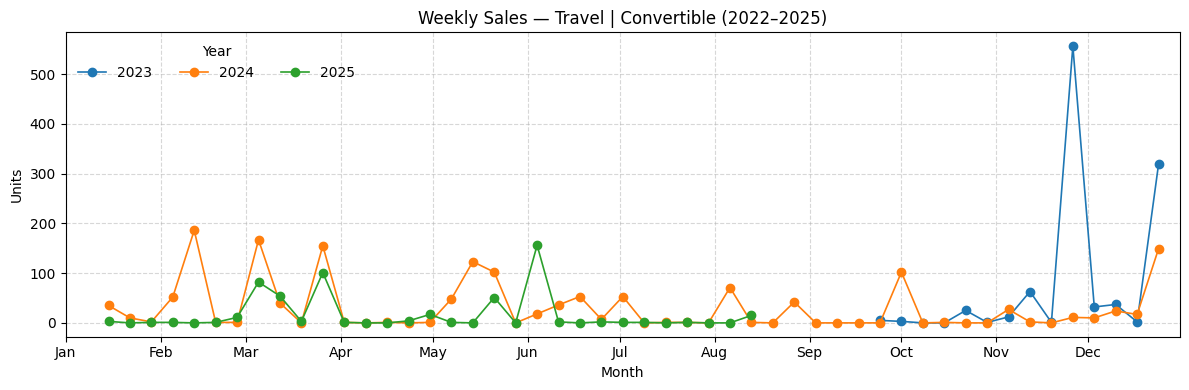

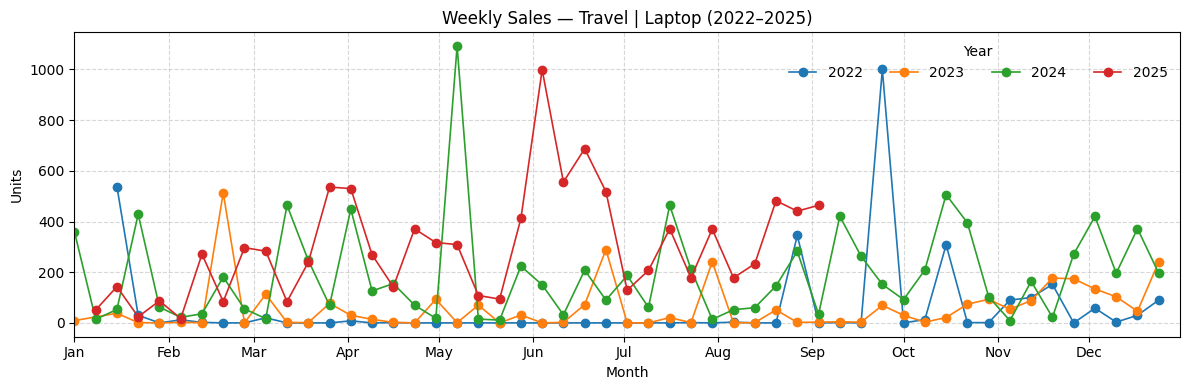

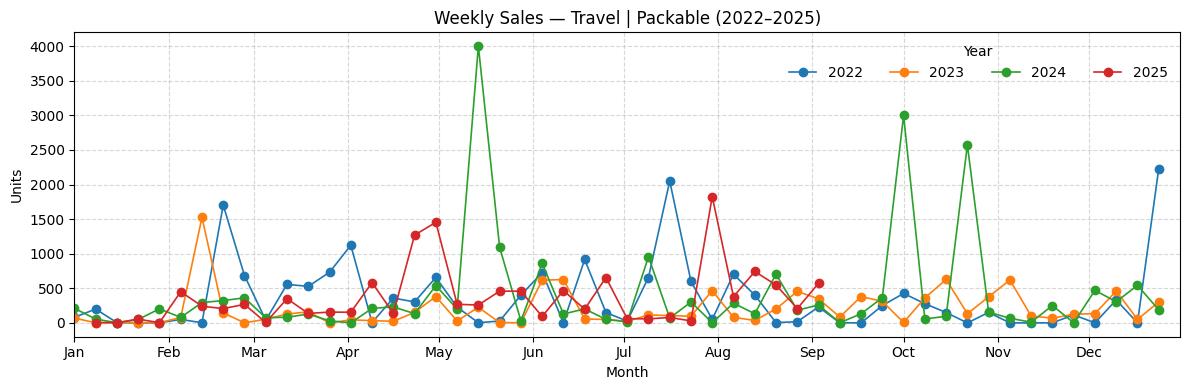

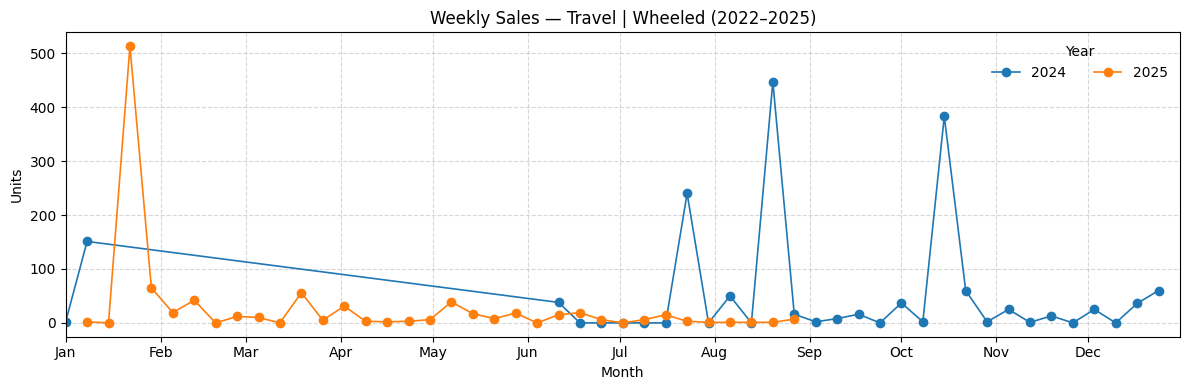

In [9]:
# ================================================================
# 7a) Weekly sales overlay (2022–2025) for BACKP by subcategory
# ================================================================
df_all = _prep(backp_df)
group_keys = (df_all.groupby(["Subcategory Desc", "CommGroup2 Desc"])
                    .size().index.tolist())

for subcat, commgrp in group_keys:
    subset = df_all[(df_all["Subcategory Desc"] == subcat) &
                    (df_all["CommGroup2 Desc"] == commgrp)]
    if subset.empty:
        continue

    fig, ax = plt.subplots(figsize=(12, 4))
    for y in YEARS:
        s = (subset[subset["year"] == y]
                .set_index("ShipDate")["SalesQty"]
                .resample(WEEK_MON).sum())
        s = weekly_dummy_align(s, week_rule=WEEK_MON, dummy_year=DUMMY_YEAR)
        if not s.empty:
            ax.plot(s.index, s.values, linewidth=1.2, marker="o", label=str(y))

    ax.set_title(f"Weekly Sales — {subcat} | {commgrp} (2022–2025)")
    ax.set_xlabel("Month"); ax.set_ylabel("Units")
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend(title="Year", ncol=4, frameon=False)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.set_xlim(datetime(DUMMY_YEAR, 1, 1), datetime(DUMMY_YEAR, 12, 31))
    plt.tight_layout(); plt.show()


## BackPack Monthly Graph Sales

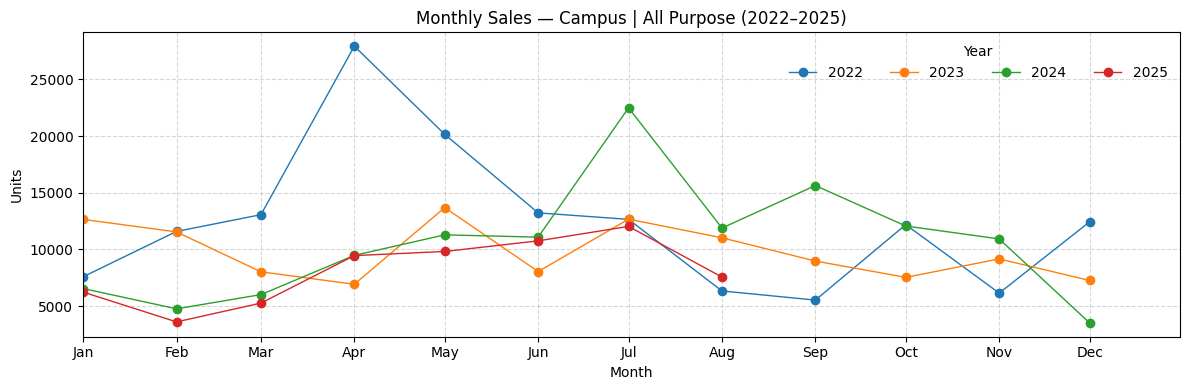

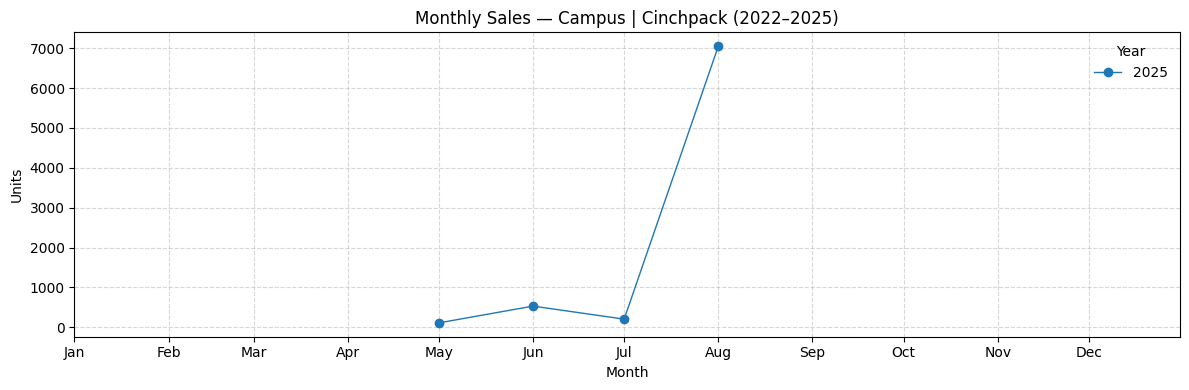

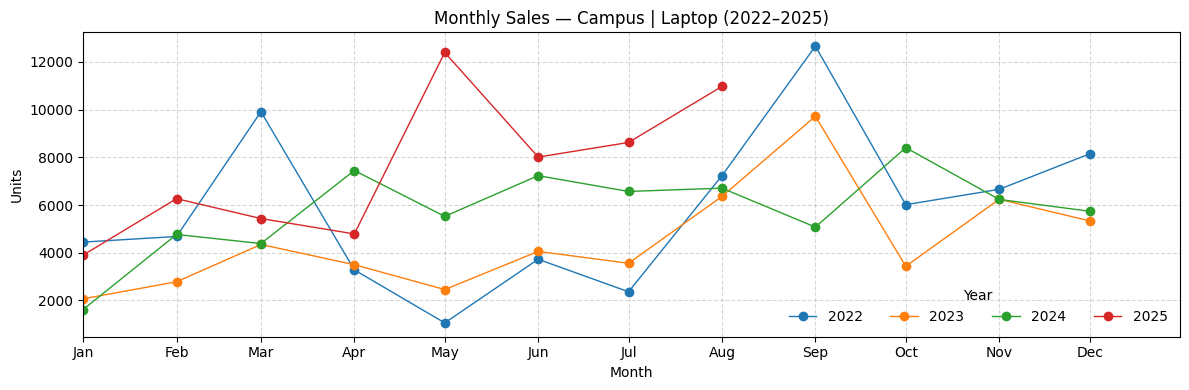

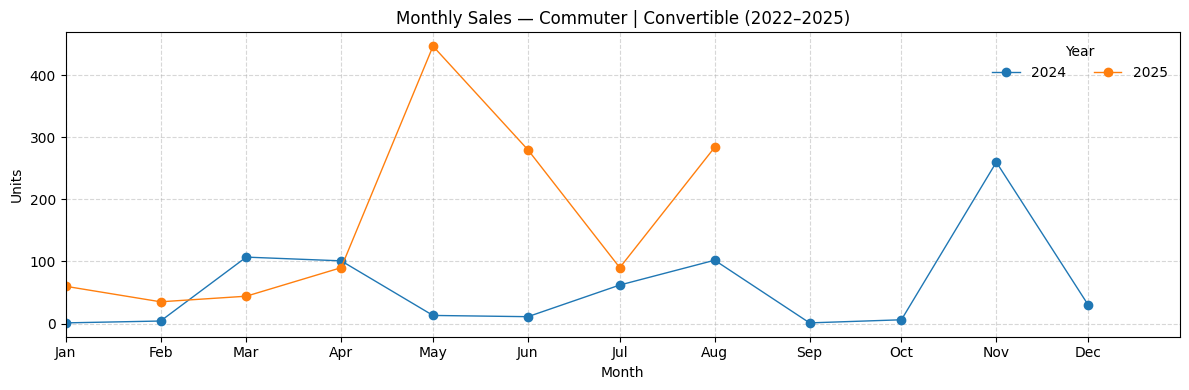

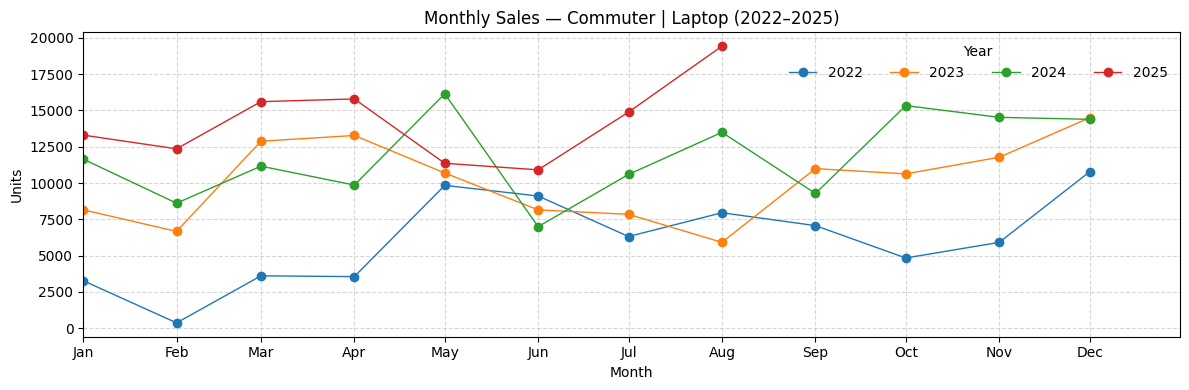

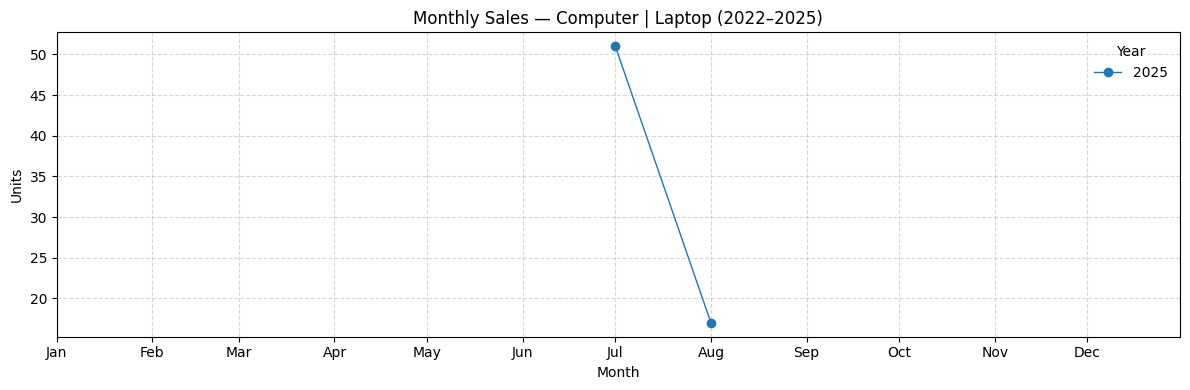

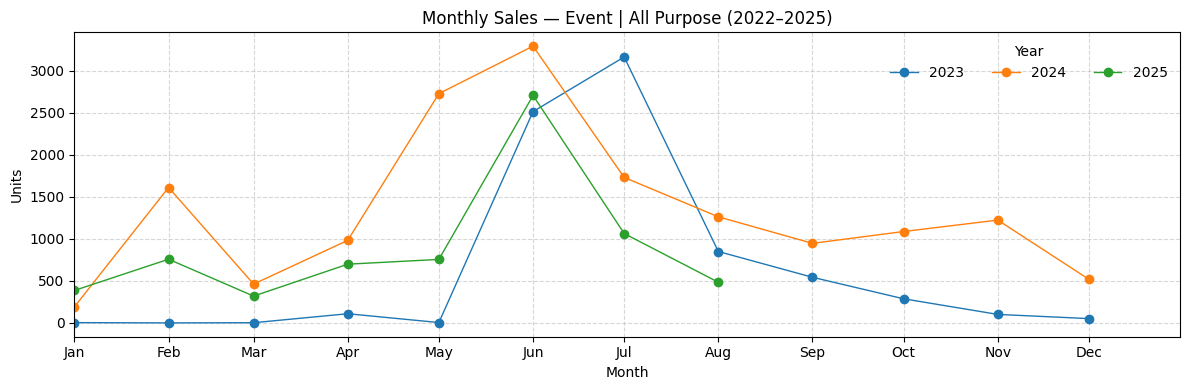

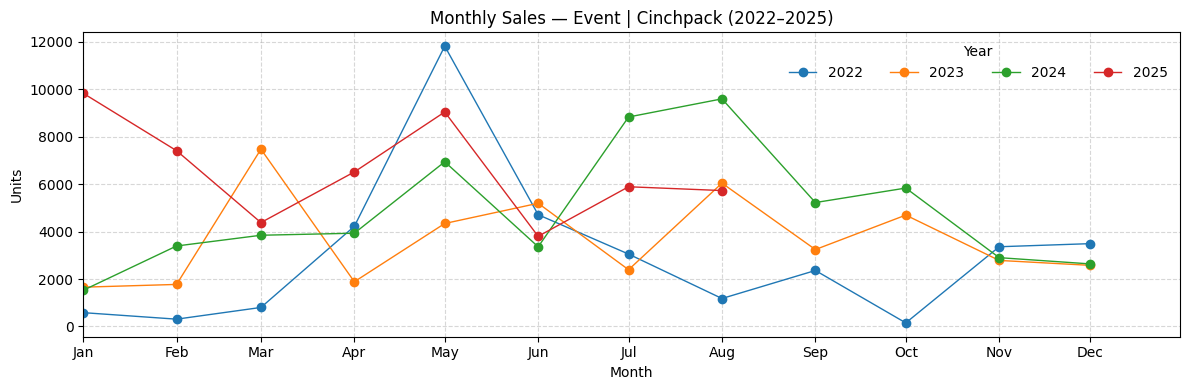

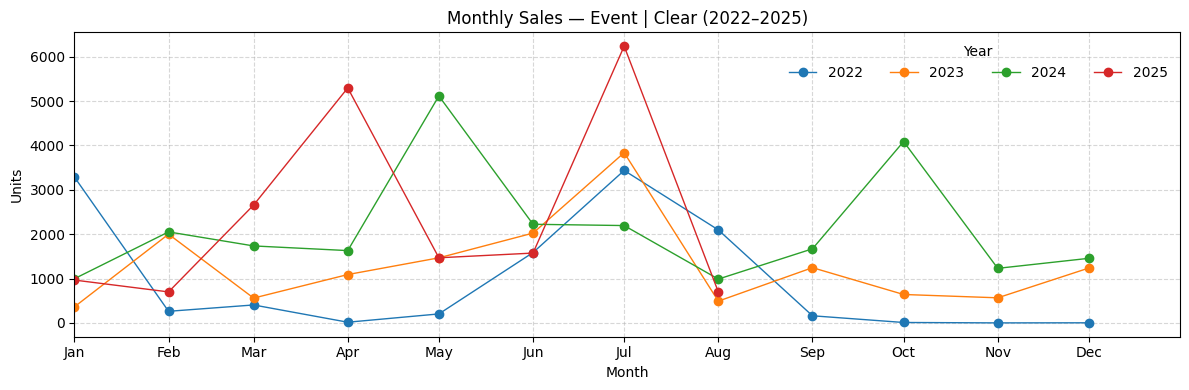

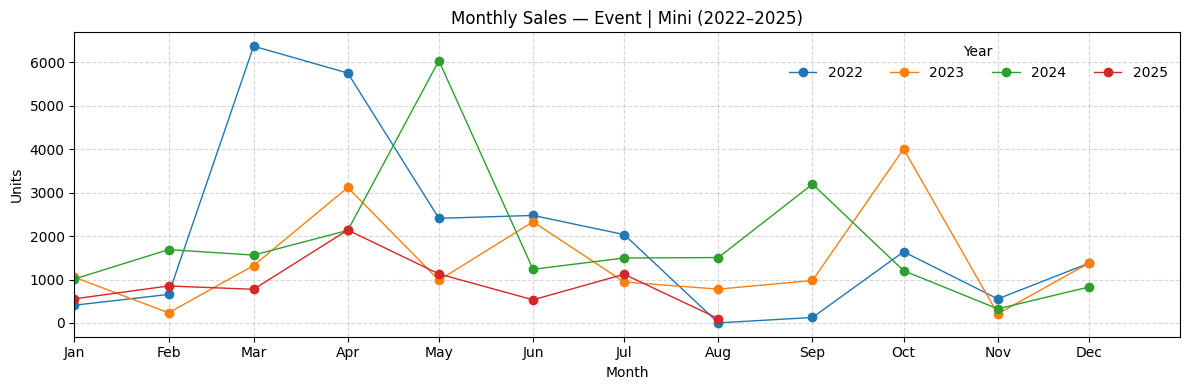

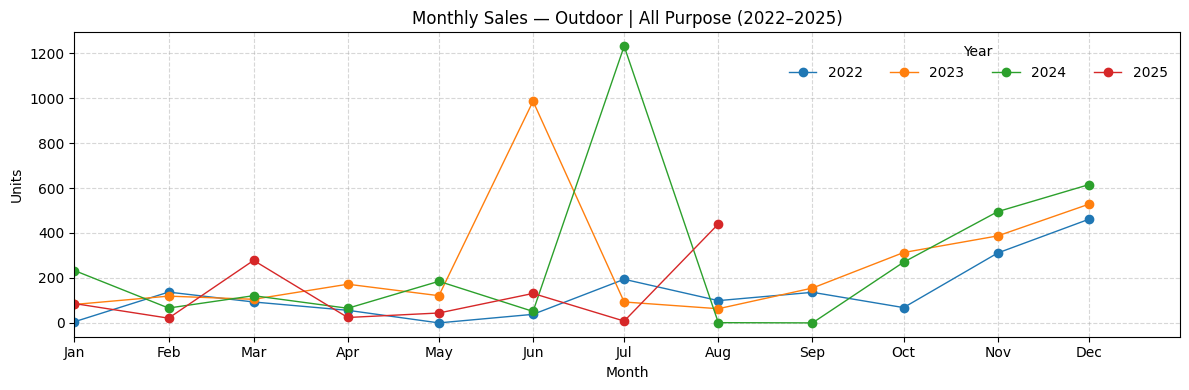

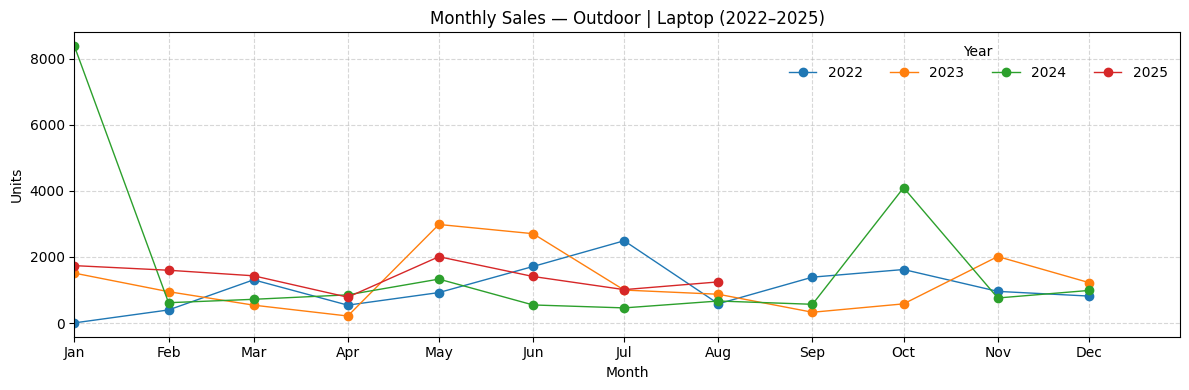

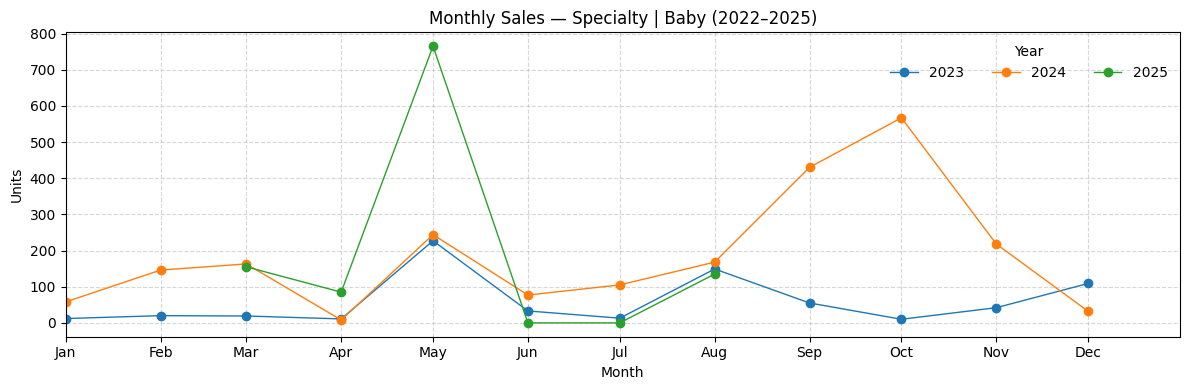

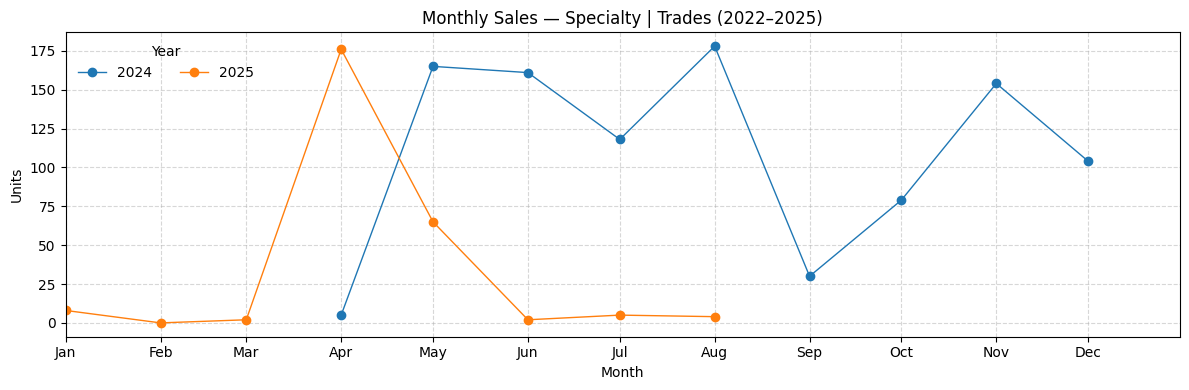

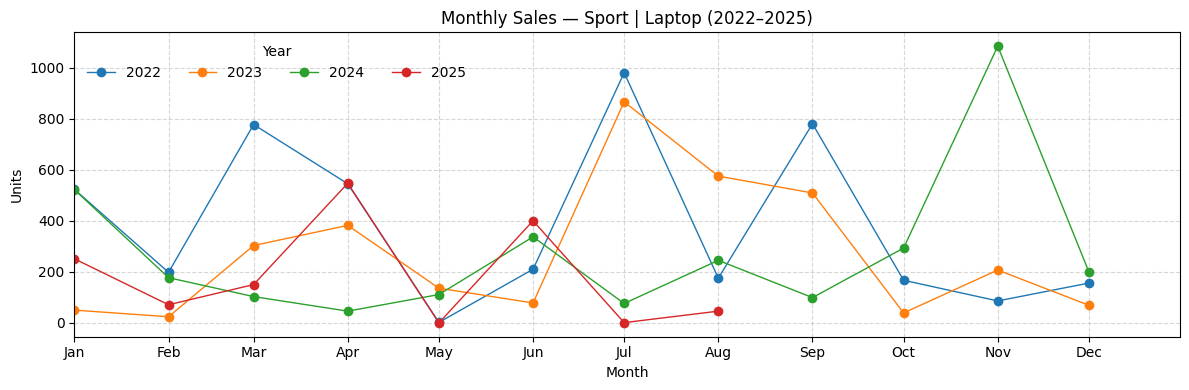

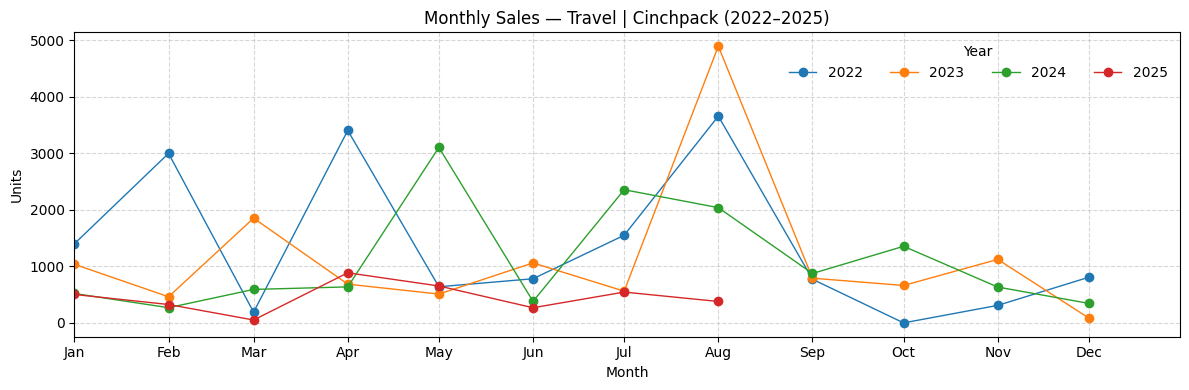

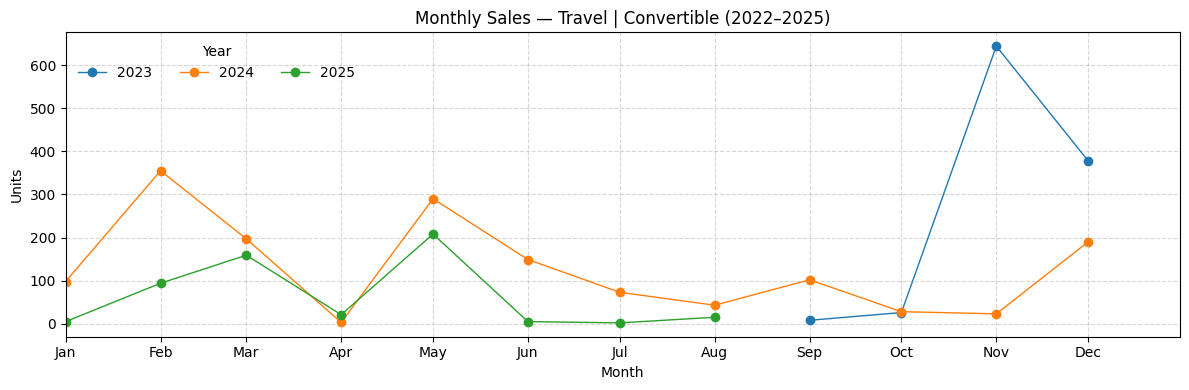

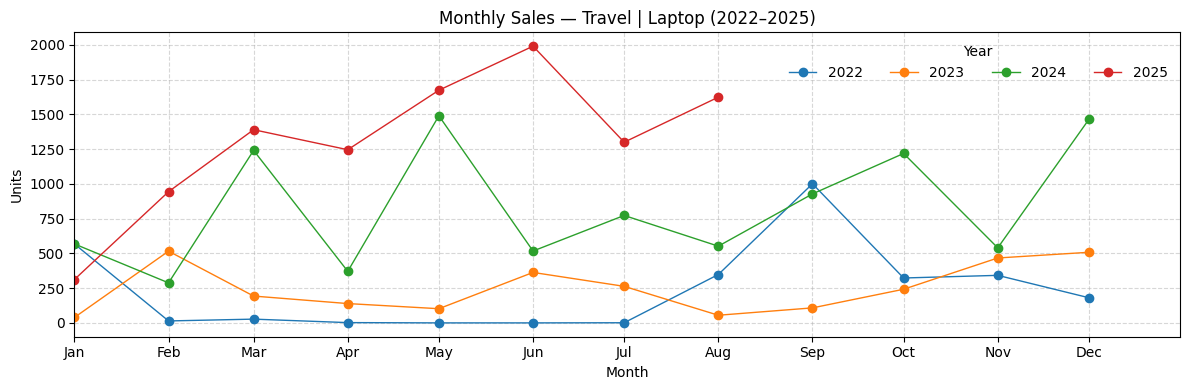

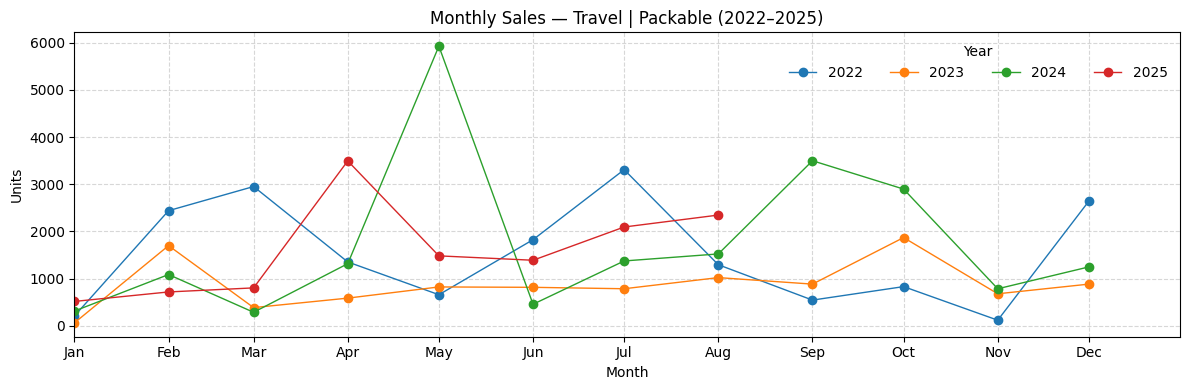

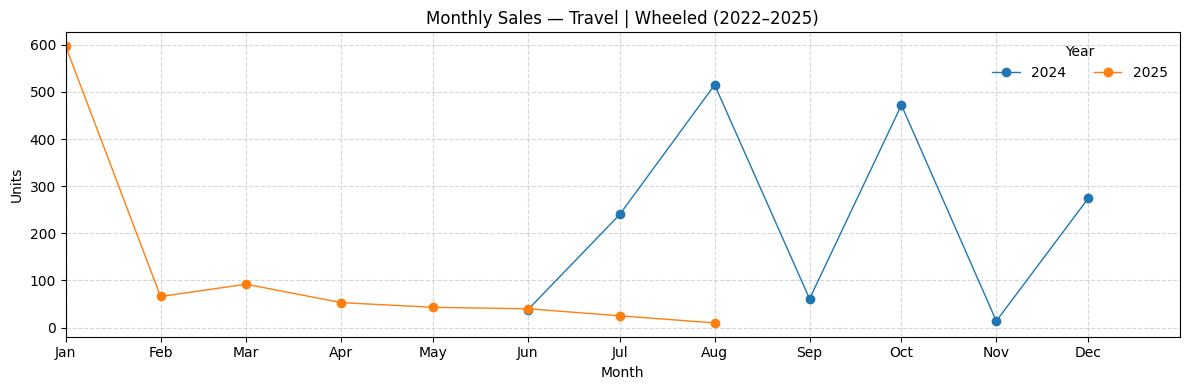

In [10]:
# ================================================================
# 7b) Monthly sales overlay (2022–2025) for BACKP by subcategory
# ================================================================
df_all = _prep(backp_df)
group_keys = (df_all.groupby(["Subcategory Desc", "CommGroup2 Desc"])
                    .size().index.tolist())

for subcat, commgrp in group_keys:
    subset = df_all[(df_all["Subcategory Desc"] == subcat) &
                    (df_all["CommGroup2 Desc"] == commgrp)]
    if subset.empty:
        continue

    fig, ax = plt.subplots(figsize=(12, 4))
    for y in YEARS:
        s = monthly_dummy_align(subset[subset["year"] == y],
                                month_rule=MONTH_RULE_OVERLAY,
                                dummy_year=DUMMY_YEAR)
        if not s.empty:
            ax.plot(s.index, s.values, marker="o", linewidth=1, label=str(y))

    ax.set_title(f"Monthly Sales — {subcat} | {commgrp} (2022–2025)")
    ax.set_xlabel("Month"); ax.set_ylabel("Units")
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend(title="Year", ncol=4, frameon=False)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.set_xlim(datetime(DUMMY_YEAR, 1, 1), datetime(DUMMY_YEAR, 12, 31))
    plt.tight_layout(); plt.show()


## Backpack Monthly Sales Table

In [11]:
# ===============================================================
# Monthly pivot for BACKP: rows=(Subcategory, CommGroup2, year)
# ===============================================================
df_use = _prep(backp_df)

agg = (
    df_use.set_index("ShipDate")
          .groupby(["Subcategory Desc", "CommGroup2 Desc", "year"])["SalesQty"]
          .resample(MONTH_RULE_PIVOT).sum()   # keep "ME" behavior you had
          .reset_index()
)
agg["month_num"] = agg["ShipDate"].dt.month

pivot_all = (
    agg.pivot_table(
        index=["Subcategory Desc", "CommGroup2 Desc", "year"],
        columns="month_num",
        values="SalesQty",
        aggfunc="sum",
    ).fillna(0)
)

pivot_all = pivot_all.reindex(columns=range(1, 13))
pivot_all.columns = [calendar.month_abbr[m] for m in pivot_all.columns]
pivot_all["Total"] = pivot_all.sum(axis=1)
pivot_all = pivot_all.sort_index(level=[0, 1, 2])

month_cols = [c for c in pivot_all.columns if c != "Total"]

def highlight_row_peaks(row):
    vals = row[month_cols]; peak = vals.max()
    return pd.Series(
        ["background-color:#137a2a; color:white; font-weight:600;" if (col in month_cols and v == peak and peak > 0) else ""
         for col, v in row.items()],
        index=row.index,
    )

def group_separators(df):
    styles = pd.DataFrame("", index=df.index, columns=df.columns)
    subcats = pd.Series(df.index.get_level_values(0), index=df.index)
    comms   = pd.Series(df.index.get_level_values(1), index=df.index)
    first_of_sub = subcats != subcats.shift(1)
    if len(first_of_sub): first_of_sub.iloc[0] = False
    styles.loc[first_of_sub[first_of_sub].index, :] = "border-top: 3px solid #1F4E79;"
    first_of_comm = (comms != comms.shift(1)) | first_of_sub
    styles.loc[first_of_comm[first_of_comm].index, :] = (
        styles.loc[first_of_comm[first_of_comm].index, :].astype(str) + "border-top: 2px solid #9BB7D6;"
    )
    return styles

styled = (
    pivot_all.style
             .format("{:,.0f}")
             .apply(highlight_row_peaks, axis=1)
             .apply(group_separators, axis=None)
             .set_table_styles([
                 {"selector": "th, td", "props": [("border", "1px solid #5A9BD5")]},
                 {"selector": "table",  "props": [("border-collapse", "collapse")]}
             ])
)
display(styled)


##Backpack Weekly Sales Table

In [12]:
# ===============================================================
# Weekly pivot (Mon→Sun) for BACKP by (Subcategory, CommGroup2, year)
# ===============================================================
df_use = _prep(backp_df)

aggW = (
    df_use.set_index("ShipDate")
          .groupby(["Subcategory Desc", "CommGroup2 Desc", "year"])["SalesQty"]
          .resample(WEEK_SUN).sum()
          .reset_index()
)

week_period            = aggW["ShipDate"].dt.to_period(WEEK_SUN)
aggW["WeekStart"]      = week_period.dt.start_time
aggW["month_num"]      = aggW["WeekStart"].dt.month
aggW["week_of_month"]  = ((aggW["WeekStart"].dt.day - 1) // 7) + 1
aggW["week_label"]     = (
    aggW["month_num"].map(lambda m: calendar.month_abbr[m]) +
    aggW["week_of_month"].map(lambda k: f" W{k}")
)

pivot_wk = (
    aggW.pivot_table(
        index=["Subcategory Desc", "CommGroup2 Desc", "year"],
        columns="week_label",
        values="SalesQty",
        aggfunc="sum",
    ).fillna(0)
)

label_order = (
    aggW[["month_num", "week_of_month", "week_label"]]
      .drop_duplicates()
      .sort_values(["month_num", "week_of_month"])
)["week_label"].tolist()

pivot_wk = pivot_wk.reindex(columns=label_order)
pivot_wk["Total"] = pivot_wk.sum(axis=1)
pivot_wk = pivot_wk.sort_index(level=[0, 1, 2])

week_cols = [c for c in pivot_wk.columns if c != "Total"]

def highlight_top3_weeks(row):
    styles = pd.Series("", index=row.index)
    vals = row[week_cols]
    if len(vals):
        ranked = vals.nlargest(min(3, len(vals)))
        if len(ranked) > 0: styles[ranked.index[0]] = "background-color:#006400; color:white; font-weight:600;"
        if len(ranked) > 1: styles[ranked.index[1]] = "background-color:#228B22; color:white; font-weight:600;"
        if len(ranked) > 2: styles[ranked.index[2]] = "background-color:#90EE90; color:black; font-weight:600;"
    return styles

def group_separators(df):
    styles = pd.DataFrame("", index=df.index, columns=df.columns)
    subcats = pd.Series(df.index.get_level_values(0), index=df.index)
    comms   = pd.Series(df.index.get_level_values(1), index=df.index)
    first_of_sub = subcats != subcats.shift(1)
    if len(first_of_sub): first_of_sub.iloc[0] = False
    styles.loc[first_of_sub[first_of_sub].index, :] = "border-top: 3px solid #1F4E79;"
    first_of_comm = (comms != comms.shift(1)) | first_of_sub
    styles.loc[first_of_comm[first_of_comm].index, :] = (
        styles.loc[first_of_comm[first_of_comm].index, :].astype(str) + "border-top: 2px solid #9BB7D6;"
    )
    return styles

styled = (
    pivot_wk.style
            .format("{:,.0f}")
            .apply(highlight_top3_weeks, axis=1)
            .apply(group_separators, axis=None)
            .set_table_styles([
                {"selector": "th, td", "props": [("border", "1px solid #5A9BD5")]},
                {"selector": "table",  "props": [("border-collapse", "collapse")]}
            ])
)
display(styled)


##Backpack T1-T3 Week Sales

In [13]:
# ======================================================================
# Top-3 weeks per (Subcategory, CommGroup2) averaged across years
# (re-uses aggW built above)
# ======================================================================
avg_by_week = (
    aggW.groupby(["Subcategory Desc", "CommGroup2 Desc", "week_label"])["SalesQty"]
        .mean()
        .reset_index()
)

avg_by_week["rank"] = (
    avg_by_week.groupby(["Subcategory Desc", "CommGroup2 Desc"])["SalesQty"]
               .rank(method="first", ascending=False)
)

top3 = avg_by_week[avg_by_week["rank"] <= 3].copy()
top3["rank"] = top3["rank"].astype(int)

pairs = sorted(top3[["Subcategory Desc", "CommGroup2 Desc"]]
               .drop_duplicates()
               .itertuples(index=False, name=None))

cols  = ["#1", "#2", "#3"]
index = pd.MultiIndex.from_product([pairs, ["Week", "Quantity"]],
                                   names=[("Subcategory Desc","CommGroup2 Desc"), ""])
result = pd.DataFrame("", index=index, columns=cols)

for (subcat, commgrp), grp in top3.groupby(["Subcategory Desc", "CommGroup2 Desc"]):
    grp = grp.sort_values("rank")
    labels = grp["week_label"].tolist()
    qtys   = grp["SalesQty"].round(0).astype(int).map(lambda x: f"{x:,}").tolist()
    while len(labels) < 3: labels.append("")
    while len(qtys)   < 3: qtys.append("")
    result.loc[((subcat, commgrp), "Week"),     cols] = labels
    result.loc[((subcat, commgrp), "Quantity"), cols] = qtys

def category_separators(df: pd.DataFrame):
    styles = pd.DataFrame("", index=df.index, columns=df.columns)
    if len(df.index): styles.loc[df.index[0], :] = "border-top: 3px solid #1F4E79;"
    qty_rows = [idx for idx in df.index if idx[1] == "Quantity"]
    styles.loc[qty_rows, :] = (styles.loc[qty_rows, :].astype(str) + "border-bottom: 3px solid #1F4E79;")
    return styles

result.index.names = [None, None]
result.columns.name = None

styled_result = (
    result.style
          .set_table_styles([
              {"selector": "th, td", "props": [("border", "1px solid #5A9BD5")]},
              {"selector": "table",  "props": [("border-collapse", "collapse")]},
              {"selector": "th.col_heading",        "props": [("text-align", "center")]},
              {"selector": "th.row_heading",        "props": [("text-align", "center")]},
              {"selector": "th.row_heading.level0", "props": [("text-align", "center")]},
              {"selector": "th",                    "props": [("text-align", "center")]},
          ])
          .set_properties(**{"text-align": "center"})
          .apply(category_separators, axis=None)
)
display(styled_result)


In [14]:
# start breaking it down by price points as well

# All Category to Yearly Sales Correlations (Month)

In [21]:
# ===============================================================
# CLEANED Peak Month Analysis (Average SALES per Month, not share)
# n > 2, & > 50% peak-month consistency
# ===============================================================

import pandas as pd, numpy as np, calendar

YEARS_USE = {2022, 2023, 2024}
G = ['CategoryName', 'Subcategory Desc', 'CommGroup2 Desc']

# --- Helper Functions ------------------------------------------------------

def prep_sales(df):
    """Standardize ShipDate, add year/month columns, and filter to target years."""
    df = df.copy()
    df['ShipDate'] = pd.to_datetime(df['ShipDate'], errors='coerce')
    df = df.dropna(subset=['ShipDate'])
    df['year'] = df['ShipDate'].dt.year
    df['month_num'] = df['ShipDate'].dt.month
    return df[df['year'].isin(YEARS_USE)]

def keep_full_years(df):
    """Keep only group-year combos that have all 12 months."""
    nmonths = df.groupby(G + ['year'])['month_num'].nunique().reset_index(name='nmonths')
    full = nmonths.loc[nmonths['nmonths'] == 12, G + ['year']]
    return df.merge(full, on=G + ['year'], how='inner')

def monthly_sales(df):
    """Compute total sales per month (no normalization)."""
    monthly_sums = (
        df.groupby(G + ['year', 'month_num'])['SalesQty']
          .sum()
          .reset_index(name='Monthly_Sales')
    )
    return monthly_sums

def wrap_prev(m, k=1):
    return ((int(m) - 1 - k) % 12) + 1

def wrap_next(m, k=1):
    return ((int(m) - 1 + k) % 12) + 1

# --- Data Prep -------------------------------------------------------------

# Expect an input DataFrame named `combined_df` with columns:
#   ShipDate, SalesQty, CategoryName, Subcategory Desc, CommGroup2 Desc
df_full = keep_full_years(prep_sales(combined_df))
monthly = monthly_sales(df_full)

# --- Identify peak months per year ----------------------------------------

monthly['rank_in_year'] = monthly.groupby(G + ['year'])['Monthly_Sales'].rank(
    method='first', ascending=False
)
top1 = monthly.loc[
    monthly['rank_in_year'] == 1, G + ['year', 'month_num', 'Monthly_Sales']
]

# --- Compute peak consistency stats ---------------------------------------

n_full = (
    monthly.groupby(G, as_index=False)['year']
           .nunique()
           .rename(columns={'year': 'N_full_years'})
)

mode_top = (
    top1.groupby(G, as_index=False)['month_num']
        .agg(lambda s: s.mode().iloc[0] if len(s) else np.nan)
        .rename(columns={'month_num': 'Peak_MonthNum'})
)

yrs_top = (
    top1.groupby(G, as_index=False)['year']
        .nunique()
        .rename(columns={'year': 'N_years_with_top'})
)

hits = (
    top1.groupby(G + ['month_num'], as_index=False)
        .size()
        .rename(columns={'size': 'Hits'})
)

conf = (
    mode_top
    .merge(hits, left_on=G + ['Peak_MonthNum'], right_on=G + ['month_num'], how='left')
    .drop(columns=['month_num'])
    .merge(yrs_top, on=G, how='left')
)
conf['Hits'] = conf['Hits'].fillna(0)
conf['Peak_Confidence'] = conf['Hits'] / conf['N_years_with_top']

# --- Average monthly SALES (across full years) -----------------------------

avg_month_sales = (
    monthly.groupby(G + ['month_num'], as_index=False)['Monthly_Sales']
           .mean()
           .rename(columns={'Monthly_Sales': 'Avg_Monthly_Sales'})
)

# Average SALES in the peak month (across years)
avg_peak_sales = (
    top1.groupby(G, as_index=False)['Monthly_Sales']
        .mean()
        .rename(columns={'Monthly_Sales': 'Avg Peak Month Sales'})
)

# Average SALES across all months (useful as a baseline)
avg_all_months_sales = (
    monthly.groupby(G, as_index=False)['Monthly_Sales']
           .mean()
           .rename(columns={'Monthly_Sales': 'Avg_AllMonths_Sales'})
)

# --- Combine base stats ----------------------------------------------------

plan = (
    mode_top
    .merge(conf[G + ['Peak_Confidence']], on=G, how='left')
    .merge(n_full, on=G, how='left')
    .merge(avg_peak_sales, on=G, how='left')
    .merge(avg_all_months_sales, on=G, how='left')
)

# Filter to stable + confident groups
plan = plan[(plan['N_full_years'] > 2) & (plan['Peak_Confidence'] > 0.5)].copy()

# --- Get pre/post average SALES (not shares) ------------------------------

def get_adjacent_sales(row):
    if pd.isna(row['Peak_MonthNum']):
        return pd.Series([np.nan, np.nan, np.nan],
                         index=['Avg Peak Month (-2) Sales',
                                'Avg Peak Month (-1) Sales',
                                'Avg Peak Month (+1) Sales'])
    gmask = (
        (avg_month_sales[G[0]] == row[G[0]]) &
        (avg_month_sales[G[1]] == row[G[1]]) &
        (avg_month_sales[G[2]] == row[G[2]])
    )
    m = int(row['Peak_MonthNum'])
    m2, m1, mp = wrap_prev(m, 2), wrap_prev(m, 1), wrap_next(m, 1)

    s2 = avg_month_sales.loc[gmask & (avg_month_sales['month_num'] == m2), 'Avg_Monthly_Sales']
    s1 = avg_month_sales.loc[gmask & (avg_month_sales['month_num'] == m1), 'Avg_Monthly_Sales']
    sp = avg_month_sales.loc[gmask & (avg_month_sales['month_num'] == mp), 'Avg_Monthly_Sales']

    # use squeeze() safely; if empty, return NaN
    v2 = s2.squeeze() if not s2.empty else np.nan
    v1 = s1.squeeze() if not s1.empty else np.nan
    vp = sp.squeeze() if not sp.empty else np.nan

    return pd.Series([v2, v1, vp],
                     index=['Avg Peak Month (-2) Sales',
                            'Avg Peak Month (-1) Sales',
                            'Avg Peak Month (+1) Sales'])

plan = pd.concat([plan, plan.apply(get_adjacent_sales, axis=1)], axis=1)

# --- Add readable columns --------------------------------------------------

plan['Peak_Month'] = plan['Peak_MonthNum'].map(lambda m: calendar.month_abbr[int(m)] if pd.notna(m) else np.nan)
plan['Peak_Confidence_%'] = (plan['Peak_Confidence'] * 100).round(1)
plan['Avg Peak Month Sales'] = plan['Avg Peak Month Sales'].round(1)
plan['Avg_AllMonths_Sales'] = plan['Avg_AllMonths_Sales'].round(1)

plan['Push_MonthNum'] = plan['Peak_MonthNum'].apply(lambda m: ((int(m) - 2) % 12) + 1 if pd.notna(m) else np.nan)
plan['Push_Month'] = plan['Push_MonthNum'].map(lambda m: calendar.month_abbr[int(m)] if pd.notna(m) else np.nan)

# --- Final organized output ------------------------------------------------

cols = G + [
    'N_full_years',
    'Peak_Month',
    'Peak_Confidence_%',
    'Avg Peak Month (-2) Sales',
    'Avg Peak Month (-1) Sales',
    'Avg Peak Month Sales',
    'Avg Peak Month (+1) Sales',
    'Avg_AllMonths_Sales',
    'Push_Month'
]

peak_summary = (
    plan[cols]
    .sort_values(G)
    .reset_index(drop=True)
)

# --- Style (simplified and consistent) ------------------------------------

def bold_peak(s):
    return ['font-weight:700;' if not pd.isna(v) else '' for v in s]

peak_summary_styled = (
    peak_summary.style
        .set_table_styles([
            {'selector': 'th, td', 'props': [('border', '1px solid #5A9BD5')]},
            {'selector': 'table',  'props': [('border-collapse', 'collapse')]},
            {'selector': 'th',     'props': [('text-align', 'center')]},
        ])
        .set_properties(**{'text-align': 'center'})
        .apply(bold_peak, subset=['Avg Peak Month Sales'])
        .background_gradient(subset=['Peak_Confidence_%'], cmap='RdYlGn', vmin=50, vmax=100)
        .format({
            'Peak_Confidence_%': '{:.1f}%',
            'Avg Peak Month (-2) Sales': '{:,.1f}',
            'Avg Peak Month (-1) Sales': '{:,.1f}',
            'Avg Peak Month Sales': '{:,.1f}',
            'Avg Peak Month (+1) Sales': '{:,.1f}',
            'Avg_AllMonths_Sales': '{:,.1f}',
        })
)

display(peak_summary_styled)
print(f"[Peak Month Summary] Groups shown: {len(peak_summary):,}")


[Peak Month Summary] Groups shown: 31


In [23]:
# ===============================================================
# EXPORT peak_summary AS PNG + CLICKABLE DOWNLOAD LINK
# ===============================================================

import matplotlib.pyplot as plt
from IPython.display import FileLink

# Use the plain DataFrame (not the styled object)
df_plot = peak_summary.copy()

# Adjust figure size based on table size
fig, ax = plt.subplots(
    figsize=(len(df_plot.columns)*1.2, 0.5*len(df_plot) + 1)
)
ax.axis('off')

# Build table
tbl = ax.table(
    cellText=df_plot.values,
    colLabels=df_plot.columns,
    cellLoc='center',
    loc='center'
)

tbl.auto_set_font_size(False)
tbl.set_fontsize(7)
tbl.scale(1.1, 1.2)

# Save PNG
png_name = "peak_summary.png"
fig.savefig(png_name, dpi=300, bbox_inches="tight")
plt.close(fig)

# Browser download link (Chrome → Downloads folder)
FileLink(png_name)


/content/peak_summary.png

## Category Correlation Tool

In [16]:
# ===============================================================
# Peak Month Analysis (Unfiltered for UI + Optional Filtered View)
#   - YEARS: 2022–2024
#   - Creates:
#       • peak_summary_all  (ALL groups, no confidence/year filters)
#       • peak_summary      (OPTIONAL: N_full_years > 2 & Peak_Confidence > 0.5)
#   - Adds numeric sales columns; NO "(XX%)" display strings
# ===============================================================

import pandas as pd
import numpy as np
import calendar

YEARS_USE = {2022, 2023, 2024}
G = ['CategoryName', 'Subcategory Desc', 'CommGroup2 Desc']

# ---------- Helpers ----------
def prep_sales(df):
    df = df.copy()
    df['ShipDate'] = pd.to_datetime(df['ShipDate'], errors='coerce')
    df = df.dropna(subset=['ShipDate'])
    df['year'] = df['ShipDate'].dt.year
    df['month_num'] = df['ShipDate'].dt.month
    return df[df['year'].isin(YEARS_USE)]

def keep_full_years(df):
    nmonths = df.groupby(G + ['year'])['month_num'].nunique().reset_index(name='nmonths')
    full = nmonths.loc[nmonths['nmonths'] == 12, G + ['year']]
    return df.merge(full, on=G + ['year'], how='inner')

def monthly_share(df):
    monthly_sums = (
        df.groupby(G + ['year', 'month_num'])['SalesQty']
          .sum().reset_index(name='Monthly_Sales')
    )
    annual = (
        monthly_sums.groupby(G + ['year'])['Monthly_Sales']
                    .sum().reset_index(name='Annual_Sales')
    )
    m = monthly_sums.merge(annual, on=G + ['year'], how='left')
    m['Monthly_Share'] = np.where(m['Annual_Sales'] > 0, m['Monthly_Sales'] / m['Annual_Sales'], np.nan)
    return m

def monthly_sales(df):
    """Raw totals per month (no normalization)."""
    return (
        df.groupby(G + ['year', 'month_num'])['SalesQty']
          .sum().reset_index(name='Monthly_Sales')
    )

def build_peak_summary(plan_df):
    """Return the tidy summary the UI expects, numeric only (no '(XX%)')."""
    out = plan_df.copy()
    out['Peak_Month'] = out['Peak_MonthNum'].map(lambda m: calendar.month_abbr[int(m)] if pd.notna(m) else np.nan)
    out['Peak_Confidence_%'] = (out['Peak_Confidence'] * 100).round(1)
    if 'Avg Peak Month Share' in out.columns:
        out['Avg Peak Month Share %'] = (out['Avg Peak Month Share'] * 100).round(1)

    # Numeric sales (rounded to 1 decimal to match your style)
    if 'Avg Peak Month Sales' in out.columns:
        out['Avg Peak Month Sales'] = out['Avg Peak Month Sales'].round(1)
    if 'Avg_AllMonths_Sales' in out.columns:
        out['Avg_AllMonths_Sales'] = out['Avg_AllMonths_Sales'].round(1)

    # Push: Peak - 1
    out['Push_MonthNum'] = out['Peak_MonthNum'].apply(lambda m: ((int(m) - 2) % 12) + 1 if pd.notna(m) else np.nan)
    out['Push_Month'] = out['Push_MonthNum'].map(lambda m: calendar.month_abbr[int(m)] if pd.notna(m) else np.nan)

    # Keep everything you already show + new numeric sales
    cols = G + [
        'N_full_years',
        'Peak_Month',
        'Peak_Confidence_%',
        # original share-based summary (if present)
        'Avg Peak Month Share %',
        # NEW numeric sales
        'Avg Peak Month Sales',
        'Avg_AllMonths_Sales',
        'Push_Month'
    ]
    cols = [c for c in cols if c in out.columns]
    return out[cols].sort_values(G).reset_index(drop=True)

# ---------- Build base tables ----------
df_full    = keep_full_years(prep_sales(combined_df))
monthly    = monthly_share(df_full)          # for share-based stats
monthly_s  = monthly_sales(df_full)          # for raw sales stats

# Shares: peak per year
monthly['rank_in_year'] = monthly.groupby(G + ['year'])['Monthly_Sales'].rank(method='first', ascending=False)
top1_share = monthly.loc[monthly['rank_in_year'] == 1, G + ['year', 'month_num', 'Monthly_Share']]

# Sales: peak per year
monthly_s['rank_in_year'] = monthly_s.groupby(G + ['year'])['Monthly_Sales'].rank(method='first', ascending=False)
top1_sales = monthly_s.loc[monthly_s['rank_in_year'] == 1, G + ['year', 'month_num', 'Monthly_Sales']]

# Common stats
n_full = monthly.groupby(G, as_index=False)['year'].nunique().rename(columns={'year': 'N_full_years'})

mode_top = top1_share.groupby(G, as_index=False)['month_num'].agg(lambda s: s.mode().iloc[0] if len(s) else np.nan) \
                     .rename(columns={'month_num': 'Peak_MonthNum'})

yrs_top = top1_share.groupby(G, as_index=False)['year'].nunique().rename(columns={'year': 'N_years_with_top'})

hits = top1_share.groupby(G + ['month_num'], as_index=False).size().rename(columns={'size': 'Hits'})

conf = (mode_top.merge(hits, left_on=G + ['Peak_MonthNum'], right_on=G + ['month_num'], how='left')
               .drop(columns=['month_num'])
               .merge(yrs_top, on=G, how='left'))
conf['Hits'] = conf['Hits'].fillna(0)
conf['Peak_Confidence'] = np.where(conf['N_years_with_top'] > 0, conf['Hits'] / conf['N_years_with_top'], np.nan)

# Averages
avg_peak_share = top1_share.groupby(G, as_index=False)['Monthly_Share'] \
                           .mean().rename(columns={'Monthly_Share': 'Avg Peak Month Share'})

avg_peak_sales = top1_sales.groupby(G, as_index=False)['Monthly_Sales'] \
                           .mean().rename(columns={'Monthly_Sales': 'Avg Peak Month Sales'})

avg_all_months_sales = monthly_s.groupby(G, as_index=False)['Monthly_Sales'] \
                                .mean().rename(columns={'Monthly_Sales': 'Avg_AllMonths_Sales'})

# ---------- Combine (UNFILTERED for the UI) ----------
plan_all = (mode_top
            .merge(conf[G + ['Peak_Confidence']], on=G, how='left')
            .merge(n_full, on=G, how='left')
            .merge(avg_peak_share, on=G, how='left')
            .merge(avg_peak_sales, on=G, how='left')
            .merge(avg_all_months_sales, on=G, how='left'))

peak_summary_all = build_peak_summary(plan_all)

# ---------- Optional filtered version for reports ----------
plan_filtered = plan_all[(plan_all['N_full_years'] > 2) & (plan_all['Peak_Confidence'] > 0.5)].copy()
peak_summary = build_peak_summary(plan_filtered)

print(f"[Peak Month Analysis] peak_summary_all rows: {len(peak_summary_all)}  |  filtered rows: {len(peak_summary)}")


[Peak Month Analysis] peak_summary_all rows: 147  |  filtered rows: 31


add the following month's share of sales

In [17]:
# ===============================================================
# Safety / Setup for Interactive Peak Month Dashboard (All Data)
# ===============================================================

required_cols = {
    'CategoryName', 'Subcategory Desc', 'CommGroup2 Desc',
    'N_full_years', 'Peak_Month', 'Peak_Confidence_%',
    # keep share in case you still want it in the UI:
    'Avg Peak Month Share %',
    'Push_Month'
}

if 'peak_summary_all' in globals():
    peak_summary = peak_summary_all.copy()
elif 'peak_summary' in globals():
    peak_summary = peak_summary.copy()
else:
    raise NameError("Expected a DataFrame named `peak_summary_all` or `peak_summary`. Please run the Peak Month analysis first.")

missing = required_cols - set(peak_summary.columns)
if missing:
    raise KeyError(f"`peak_summary` is missing columns: {sorted(missing)}")

# Clean up dropdown columns
_sel = peak_summary.copy()
_sel['Subcategory Desc_sel'] = _sel['Subcategory Desc'].fillna('(Missing)').astype(str).str.strip()
_sel['CommGroup2 Desc_sel']  = _sel['CommGroup2 Desc'].fillna('(Missing)').astype(str).str.strip()

ALL = 'All'
cat_options = sorted(_sel['CategoryName'].dropna().astype(str).unique())


In [18]:
# ===============================================================
# Dropdowns + Clear Buttons
# ===============================================================

import ipywidgets as widgets

# --- Widgets ---
cat_dd = widgets.Dropdown(
    options=[('— choose a Category —', '')] + [(c, c) for c in cat_options],
    value='',
    description='Category:', layout=widgets.Layout(width='420px')
)
sub_dd = widgets.Dropdown(
    options=[('All', 'All')], value='All',
    description='Subcategory:', layout=widgets.Layout(width='420px')
)
cg_dd = widgets.Dropdown(
    options=[('All', 'All')], value='All',
    description='CommGroup2:', layout=widgets.Layout(width='420px')
)

# --- Safe option setter ---
def _first_value(opts):
    if not opts: return None
    o = opts[0]
    if isinstance(o, (list, tuple)) and len(o) == 2:
        return o[1]
    return o

def _safe_set_options(dd, opts, value=None):
    dd.options = opts
    if value is None:
        value = _first_value(opts)
    try:
        dd.value = value
    except Exception:
        dd.value = _first_value(opts)

# --- Update dropdowns ---
def update_sub_options(category):
    if not category:
        _safe_set_options(sub_dd, [('All', 'All')], 'All')
        update_cg_options('', 'All')
        return
    subs = sorted(
        _sel.loc[_sel['CategoryName'] == category, 'Subcategory Desc_sel']
            .dropna().unique().tolist()
    )
    _safe_set_options(sub_dd, [('All', 'All')] + [(v, v) for v in subs], 'All')
    update_cg_options(category, 'All')

def update_cg_options(category, subcat_sel):
    if not category:
        _safe_set_options(cg_dd, [('All', 'All')], 'All')
        return
    df = _sel[_sel['CategoryName'] == category]
    if subcat_sel != 'All':
        df = df[df['Subcategory Desc_sel'] == subcat_sel]
    cgs = sorted(df['CommGroup2 Desc_sel'].dropna().unique().tolist())
    _safe_set_options(cg_dd, [('All', 'All')] + [(v, v) for v in cgs], 'All')

# --- Buttons ---
clear_cat_btn = widgets.Button(description='Clear', layout=widgets.Layout(width='80px'))
clear_sub_btn = widgets.Button(description='Clear', layout=widgets.Layout(width='80px'))
clear_cg_btn  = widgets.Button(description='Clear', layout=widgets.Layout(width='80px'))

out = widgets.Output()

# --- Clear button logic ---
def on_clear_cat_clicked(_):
    _safe_set_options(cat_dd, [('— choose a Category —', '')] + [(c, c) for c in cat_options], value='')
    update_sub_options('')
    render_table()

def on_clear_sub_clicked(_):
    _safe_set_options(sub_dd, sub_dd.options, value='All')
    update_cg_options(cat_dd.value, 'All')
    render_table()

def on_clear_cg_clicked(_):
    _safe_set_options(cg_dd, cg_dd.options, value='All')
    render_table()


In [19]:
# ===============================================================
# Render + Observers + Legend
# ===============================================================
def render_table():
    with out:
        clear_output(wait=True)

        category   = cat_dd.value
        subcat_sel = sub_dd.value
        cg_sel     = cg_dd.value

        if not category:
            print("Pick a Category to begin.")
            return

        df = _sel[_sel['CategoryName'] == category].copy()
        if subcat_sel != 'All':
            df = df[df['Subcategory Desc_sel'] == subcat_sel]
        if cg_sel != 'All':
            df = df[df['CommGroup2 Desc_sel'] == cg_sel]

        if df.empty:
            print("No rows match this selection.")
            return

        # Your original base columns:
        cols = [
            'CategoryName', 'Subcategory Desc', 'CommGroup2 Desc',
            'N_full_years', 'Peak_Month', 'Peak_Confidence_%',
            'Avg Peak Month Share %', 'Push_Month'
        ]

        # NEW numeric sales columns if present (kept numeric; no '(XX%)'):
        extra_sales = [c for c in ['Avg Peak Month Sales', 'Avg_AllMonths_Sales'] if c in df.columns]

        # Insert sales after Peak_Confidence_% for readability:
        insert_at = cols.index('Peak_Confidence_%') + 1
        cols = cols[:insert_at] + extra_sales + cols[insert_at:]

        df = df[cols].reset_index(drop=True)

        styled = (
            df.style
              .set_table_styles([
                  {'selector': 'th, td', 'props': [('border', '1px solid #5A9BD5')]},
                  {'selector': 'table',  'props': [('border-collapse', 'collapse')]},
                  {'selector': 'th',     'props': [('text-align', 'center')]},
              ])
              .set_properties(**{'text-align': 'center'})
              .background_gradient(subset=['Peak_Confidence_%'], cmap='RdYlGn', vmin=0, vmax=100)
              .format({
                  'Peak_Confidence_%': '{:.1f}%',
                  'Avg Peak Month Share %': '{:.1f}%',
                  **({ 'Avg Peak Month Sales': '{:,.1f}' } if 'Avg Peak Month Sales' in df.columns else {}),
                  **({ 'Avg_AllMonths_Sales': '{:,.1f}' } if 'Avg_AllMonths_Sales' in df.columns else {}),
              })
        )
        display(styled)

# --- Observers ---
def on_cat_change(change):
    if change['name'] != 'value': return
    update_sub_options(change['new'])
    render_table()

def on_sub_change(change):
    if change['name'] != 'value': return
    update_cg_options(cat_dd.value, change['new'])
    render_table()

def on_cg_change(change):
    if change['name'] != 'value': return
    render_table()

cat_dd.observe(on_cat_change)
sub_dd.observe(on_sub_change)
cg_dd.observe(on_cg_change)

clear_cat_btn.on_click(on_clear_cat_clicked)
clear_sub_btn.on_click(on_clear_sub_clicked)
clear_cg_btn.on_click(on_clear_cg_clicked)

controls = widgets.VBox([
    widgets.HBox([cat_dd, clear_cat_btn]),
    widgets.HBox([sub_dd, clear_sub_btn]),
    widgets.HBox([cg_dd,  clear_cg_btn]),
])
display(controls, out)

# Initialize
update_sub_options('')
render_table()


Output()